In [1]:
get_ipython().system('nvidia-smi')

Mon Mar 18 16:38:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:08:00.0 Off |                  N/A |
| 82%   86C    P2   185W / 260W |   9723MiB / 11019MiB |     76%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:42:00.0 Off |                  N/A |
| 41%   

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#!pip install tqdm

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers  
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import math
import keras as k
import pandas as pd
import numpy as np
from copy import copy
import scipy.io
from sklearn.decomposition import PCA
import random
from scipy.signal import find_peaks
from scipy import interpolate
from numpy import sin,cos,pi,array,linspace,cumsum,asarray,dot,ones
from pylab import plot, legend, axis, show, randint, randn, std,lstsq

from sklearn.manifold import MDS
import csv
import os
from pandas import read_csv
import ranges
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.special import iv

from sklearn.manifold import MDS
import csv
import os
from tqdm import tqdm 
from scipy import stats
import statistics

In [6]:
# The path to save the models and read data from

### !!! please create and name the main folder that you would like to save all results -- ensure that the functions and data files are in this folder
folder = 'YA_Analysis'

path = '/home/twinner/'+ folder

# Insert the directory
import sys
sys.path.insert(0,path)


In [7]:
# Define these variables  specifically for your dataset!

# number of samples in each trial
trialsamp = 6000 #time series (samples) per trial


# load the input data
# -------------------2D kinematics ----------------------------
#datafilepath0 = path + '/DataStorage_6000_2D_kinematics_clean.csv' # path to input data
#inputdata = read_csv(datafilepath0, header = None)
#inputdata = inputdata.to_numpy()
#print('2D kinematics input data shape is: '+ str(inputdata.shape ))

#arr = all_csvnp.to_numpy() #convert to numpy array

# reshape all the input data into a tensor
#all_inputdata = arr.reshape(trialnum,trialsamp,feats) 
#all_inputdata = arr # if tensor not needed


# ------------------- 3D kinematics ----------------------------

#datafilepath1 = path + '/DataStorage_6000_3D_kinematics_clean.csv' # path to input data
#inputdata = read_csv(datafilepath1, header = None)
#inputdata = inputdata.to_numpy()
#print('3D kinematics input data shape is: '+ str(inputdata.shape ))

# ------------------- kinetics ----------------------------

#datafilepath2 = path + '/DataStorage_6000_kinetics_clean_031524.csv' # path to input data
#inputdata = read_csv(datafilepath2, header = None)
#inputdata = inputdata.to_numpy()
#print('kinetics input data shape is: '+ str(inputdata.shape ))


# ------------------- 3D kinematics + kinetics ----------------------------

datafilepath = path + '/DataStorage_6000_kinematics_and_kinetics_clean_031524.csv' # path to input data
inputdata = read_csv(datafilepath, header = None)
inputdata = inputdata.to_numpy()
print('3D kinematics + kinetics input data shape is: '+ str(inputdata.shape ))



# -------------------- Load in predictor variable----------------------------


# Load in the Speeds
datafilepath6 = path + '/speeds_label.csv' # path to input data
keydata = read_csv(datafilepath6, header = None)
speed = keydata.to_numpy() #convert to numpy array
print('Speed data shape is: '+ str(speed.shape ))


# Load in the Individuals
datafilepath7 = path + '/subject_num_label.csv' # path to input data
keydata = read_csv(datafilepath7, header = None)
SubjectID = keydata.to_numpy() #convert to numpy array
print('SubjectID shape is: '+ str(SubjectID.shape ))


# number of trials in dataset 
trialnum = len(speed) #subjects and speeds

#Batch size - same as the number of trials
batch_size = trialnum

inshape = inputdata.shape[1]
feats = inputdata.shape[0]

#data_type = '_Paper2_2Dkinematics_gaitsigs'

mod_name = '/Paper2_RAWDATA_phaseaveraged/'
model_name  = 'Alldata_phaseavg_nopca_031624'

3D kinematics + kinetics input data shape is: (60, 900000)
Speed data shape is: (150, 1)
SubjectID shape is: (150, 1)


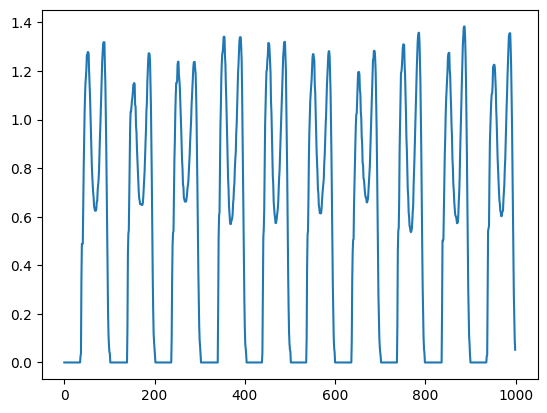

In [8]:
#all_inputdata_s = inputdata.reshape(trialnum,trialsamp,feats) 
all_inputdata_s = inputdata.T.reshape(trialnum,trialsamp,feats) 
plt.plot(all_inputdata_s[0,0:1000,20].T)

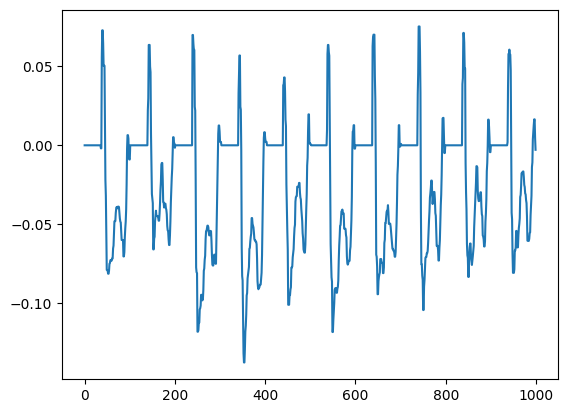

In [11]:
plt.plot(all_inputdata_s[13,0:1000,18].T)

#### Extract sagittal plane data for phaser

In [11]:
# Load 2D kimematics for phaser

# -------------------2D kinematics ----------------------------
datafilepath0 = path + '/DataStorage_6000_2D_kinematics_clean.csv' # path to input data
phaserinputdata = read_csv(datafilepath0, header = None)
phaserinputdata = phaserinputdata.to_numpy()
print('2D kinematics input data shape is: '+ str(phaserinputdata.shape ))

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler =  StandardScaler()  #MinMaxScaler()
scaler.fit(phaserinputdata.T) # fit scaler on training data only 

# scale all the input data 
phaserinputdata_s = scaler.transform(phaserinputdata.T) #transform
#print('scaled input data shape is: '+ str(phaserinputdata_s.shape ))
#print(scaler.mean_) # to get the mean for every column
#print(scaler.var_) # to get the variance for every column

all_phaserinputdata_s = phaserinputdata_s.reshape(trialnum,trialsamp,6)
print('UPDATED 2D kinematics input data shape is: '+ str(all_phaserinputdata_s.shape ))
#all_phaserinputdata_s = phaserinputdata_s.reshape(trialnum,trialsamp,6)  #testing change --> this was before
# update the phaser algorithm as follows 
#raw = all_phaserinputdata_s[a,:,[0,3]] #update in the phaser part of algorithm

2D kinematics input data shape is: (6, 900000)
UPDATED 2D kinematics input data shape is: (150, 6000, 6)


In [12]:
all_phaserinputdata_s.shape

(150, 6000, 6)

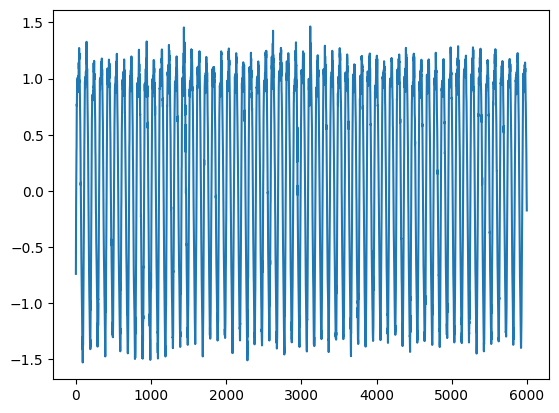

In [13]:
plot(all_phaserinputdata_s[0][:,0])

In [14]:
# To stop output to client from server
#NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
#NotebookApp.rate_limit_window=3.0 (secs)

### Generate Phase Averaged PCA Signatures

In [15]:
import fourierseries
import util
import phaser
import dataloader
# Preprocess data for a single subject - to be send to modeling frameworks
def find_phase(k):
    """
    Detrend and compute the phase estimate using Phaser
    INPUT:
      k -- dataframe
    OUTPUT:
      k -- dataframe
    """
    #l = ['hip_flexion_l','hip_flexion_r'] # Phase variables = hip flexion angles
    y = np.array(k)
    print(y.shape)
    y = util.detrend(y.T).T
    print(y.shape)
    phsr = phaser.Phaser(y=y)
    k[:] = phsr.phaserEval(y)[0,:]
    return k

Running phaser


In [16]:
def vonMies(t,t_0, b):
    out = np.exp(b*np.cos(t-t_0))/(2*pi*iv(0, b))
    return out

In [17]:
def gaitphasegenerator(trial_len,AGRF_phases,PvsNP):
    # takes in the length of trial, the ground truth phases for each trial and the paretic side of the subj/trials
    # exports a gait phase at each phase transition with zeros between
    # Because paretic vs. non-paretic data were swapped in the data the LOCATIONS of gait events need to be swapped in the phases as well to align.
    g_phase = np.zeros([trial_len, 1])
    for q in range(trial_len-1):
        if PvsNP == 'R':
            if (g_phaselabels[q+1]-g_phaselabels[q]) ==1: # if transitions are from 1->2,2->3,3->4 then:
                if (g_phaselabels[q] ==1 and g_phaselabels[q+1] ==2):
                    g_phase[q] = 2 # paretic toe off
                if (g_phaselabels[q] ==2 and g_phaselabels[q+1] ==3):
                    g_phase[q] = 3 # paretic heel strike
                if (g_phaselabels[q] ==3 and g_phaselabels[q+1] ==4):
                    g_phase[q] = 4 # non-paretic toe off
            elif (g_phaselabels[q+1] ==1 and g_phaselabels[q]) ==4: # OR (g_phaselabels[q+1]-g_phaselabels[q]) == -3  when 4 (RHS) goes to 1 (LTO)
                g_phase[q] = 1 #non-paretic heel strike
        elif PvsNP =='L': #Flip all the events for the paretic side being reversed
            if (g_phaselabels[q+1]-g_phaselabels[q]) ==1: #if transitions are from 1->2,2->3,3->4 then:
                if (g_phaselabels[q] ==1 and g_phaselabels[q+1] ==2):
                    g_phase[q] = 4
                if (g_phaselabels[q] ==2 and g_phaselabels[q+1] ==3):
                    g_phase[q] = 1
                if (g_phaselabels[q] ==3 and g_phaselabels[q+1] ==4):
                    g_phase[q] = 2
            elif (g_phaselabels[q+1] ==1 and g_phaselabels[q]) ==4:
                g_phase[q] = 3
    return g_phase

In [18]:
datafilepath4 = path + '/gaitphase_label.csv'
keydata = read_csv(datafilepath4, header = None)
gaitphaselabels = keydata.to_numpy() #convert to numpy array
gaitphaselabels.shape

(150, 6000)

In [19]:
# Create a list of 150 strings containing 'R'
PareticSide = ['R' for _ in range(trialnum)]
# Print the list to verify
#print(PareticSide)

generating phase averaged PCA signatures
['processing trial: 0']
['processing trial: 1']
['processing trial: 2']
['processing trial: 3']
['processing trial: 4']
['processing trial: 5']
['processing trial: 6']
['processing trial: 7']
['processing trial: 8']
['processing trial: 9']
['processing trial: 10']
['processing trial: 11']
['processing trial: 12']
['processing trial: 13']
['processing trial: 14']
['processing trial: 15']
['processing trial: 16']


/home/twinner/YA_Analysis/phaser.py:399: UserWarning: PhaserForSample:nCycMismatch
  warnings.warn( "PhaserForSample:nCycMismatch" )


['processing trial: 17']
['processing trial: 18']
['processing trial: 19']
['processing trial: 20']
['processing trial: 21']
['processing trial: 22']
['processing trial: 23']
['processing trial: 24']
['processing trial: 25']
['processing trial: 26']
['processing trial: 27']
['processing trial: 28']
['processing trial: 29']
['processing trial: 30']
['processing trial: 31']
['processing trial: 32']
['processing trial: 33']
['processing trial: 34']
['processing trial: 35']
['processing trial: 36']
['processing trial: 37']
['processing trial: 38']
['processing trial: 39']
['processing trial: 40']
['processing trial: 41']
['processing trial: 42']
['processing trial: 43']
['processing trial: 44']
['processing trial: 45']
['processing trial: 46']
['processing trial: 47']
['processing trial: 48']
['processing trial: 49']
['processing trial: 50']
['processing trial: 51']
['processing trial: 52']
['processing trial: 53']
['processing trial: 54']
['processing trial: 55']
['processing trial: 56']


/opt/anaconda3/envs/taniel/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


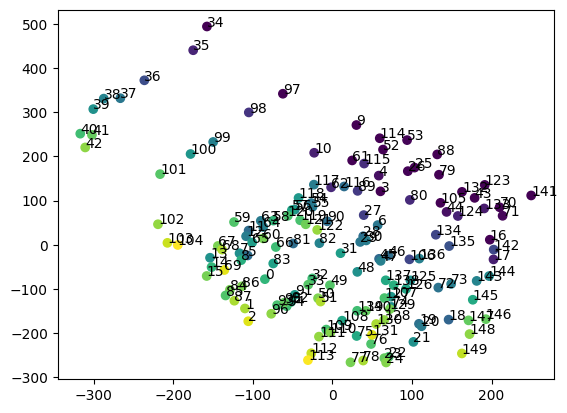

In [20]:
for j in range(1):

    g_phaselabels = gaitphaselabels
    phase_out = gaitphasegenerator(trialsamp,g_phaselabels,PareticSide)


    # Specify variables for model run instance

    numunits = feats # features in dataset
    
    test_ind = np.arange(0, trialnum, 1)  # run all input data through

    ext_drive= trialsamp

    # Generate SHIFTED phase averaged signatures

    print('generating phase averaged PCA signatures')
    # phase length = 100
    lim = trialnum
    L = feats # lets look at all features
    PhaseAveragedPCs = np.empty(shape=[lim, L, 100])
    PhaseAveragedPCs_shift = np.empty(shape=[lim, L, 100])
    PhaseAveragedPCs_shift_LHS = np.empty(shape=[lim, L, 100]) # align to left heel strike shift

    Phase_Variables = np.empty(shape=[lim, trialsamp])
    GaitPhases_phsavg = np.empty([0,100])

    cyclephase = []
    PC_Shifts = np.empty(shape=[lim]) # store phase shift values
    # Average orbits initialization
    numSegments = 100 # we want each Phase averaged orbit to be 100 sample points long
    phaseVals = np.linspace(0, 2*pi, numSegments, endpoint=True) # phases that we want our phase averaged orbits to correspond to
    a1 = np.round(phaseVals,1)
    kappa = 20

    for a in range(lim): #for length of all the trials
        print(['processing trial: ' + str(a)])
        dats=[] # reset variables after each trial - kinematics
        dats2 = [] # reset the HC params

        allsigs = np.empty(shape=[100,])
        all_phase_var = np.empty(shape=[100,])
        PhaseAvgPCs = np.empty(shape=[100])
        PhsAvgGaitPhase = np.zeros([100,1])

        all_cyclephase = []
        raw = all_phaserinputdata_s[a,:,[0,3]] #use hip angles to find phase
        #raw = HC_CellArray[a][:,0:feats].T # Only use 1st 3 PCs (of HCs),
        raw2 = all_inputdata_s[a,:,:].T  # extract all RAW data features
        for b in range(6): #Shai's code does duplication- works better than without duplicating data
            dats.append(raw-raw.mean(axis=1)[:,np.newaxis]) #center the HCs data for phase estimation -- this centers each one separately
            dats2.append(raw2-raw2.mean(axis=1)[:,np.newaxis])
        #rHC = dats2[0] #centered
        rHC = raw2 #uncentered
        phr = phaser.Phaser(dats) # use centered data from 1st 3 PCs
        phi = [ phr.phaserEval( d ) for d in dats ] # extract phase
        phi2  =(phi[0].T % (2*pi)); # Take modulo s.t. phase ranges from [0,2*pi]

        # Estimate gait phases
        g_phaselabels = gaitphaselabels[a]
        PVNP = 'R'
        phase_out = gaitphasegenerator(trialsamp,g_phaselabels,PVNP)
        LHS =  np.where(phase_out == 1)
        RTO =  np.where(phase_out == 2)
        RHS =  np.where(phase_out == 3)
        LTO =  np.where(phase_out== 4)   
        
        # new method
        LHS_phase = np.round(statistics.mode(np.round(phi2[LHS[0]],1).flatten()),1)
        RTO_phase = np.round(statistics.mode(np.round(phi2[RTO[0]],1).flatten()),1)
        RHS_phase = np.round(statistics.mode(np.round(phi2[RHS[0]],1).flatten()),1)
        LTO_phase = np.round(statistics.mode(np.round(phi2[LTO[0]],1).flatten()),1)
  
        LHS_event = np.where(a1  == LHS_phase)
        RTO_event = np.where(a1  == RTO_phase)
        RHS_event = np.where(a1  == RHS_phase)
        LTO_event = np.where(a1  == LTO_phase)
        
        #display(LHS_event[0][0],RTO_event[0][0],RHS_event[0][0],LTO_event[0][0])
        
        
        PhsAvgGaitPhase[LHS_event[0][0]] = 1
        PhsAvgGaitPhase[RTO_event[0][0]] = 2
        PhsAvgGaitPhase[RHS_event[0][0]] = 3
        PhsAvgGaitPhase[LTO_event[0][0]] = 4


        GaitPhases_phsavg = np.concatenate((GaitPhases_phsavg,PhsAvgGaitPhase.T), axis = 0)

        # find average orbits
        avgOrbits = np.zeros((numSegments,L)) #initialize avg orbits
        phases = np.reshape(phi2,[trialsamp,]) #this was the error!!!!!

        for c in range(numSegments): #number of points in final average orbit/phase averaging
            vonMiesCurrent = vonMies(phases,phaseVals[c],kappa) # for each value in the num of phase points calculate current
            sumVal = np.sum(vonMiesCurrent)

            for d in range(L):  # for the number of features or units
                data = np.reshape(rHC[d,:],[trialsamp,1])
                avgOrbits[c,d] = np.sum(data.T*vonMiesCurrent)/sumVal # phase point (row), feature of PC (column) -- this is generating a value for the 1st phase point of each feature

        PhaseAveragedPCs[a] = avgOrbits.T # transform to match overall saving structure as before
        phi2 = phi2.reshape(trialsamp,)
        Phase_Variables[a] = phi2 # store phase variables for all cycles/features - may need to phase shift these

        # Phase shift the data according to PC1 max align with zero phase
        PC1_maxloc = np.argmax(PhaseAveragedPCs[a][0]) # only PC1 value (1st max if repeated)
        Data2Shift = PhaseAveragedPCs[a]
        NewP = np.roll(Data2Shift, -PC1_maxloc,axis=1) #shift backwards to orgin
        PC_Shifts[a] = PC1_maxloc
        PhaseAveragedPCs_shift[a] = NewP

    #### Forward fill/back-fill events for the phase averaged kinematics
    GaitPhases_phsavg_fill = np.empty([0,100])
    GaitPhases_phsavg_fill_shift = np.empty([lim,100])
    GaitPhases_phsavg_fill_shift_LHS = np.empty([lim,100])

    for ind in range(len(GaitPhases_phsavg)):
        filled_phases = np.zeros([100,1])
        gaitindices = np.where(GaitPhases_phsavg[ind] != 0)
        if gaitindices[0][0] != 0:
            filled_phases[0:gaitindices[0][0]] = GaitPhases_phsavg[ind][gaitindices[0][3]] # first section has to be gait phase from before (so last gait event)
            filled_phases[gaitindices[0][0]:gaitindices[0][1]] = GaitPhases_phsavg[ind][gaitindices[0][0]] # second section has to be gait phase from before (so first gait event)
            filled_phases[gaitindices[0][1]:gaitindices[0][2]] = GaitPhases_phsavg[ind][gaitindices[0][1]] # third section
            filled_phases[gaitindices[0][2]:gaitindices[0][3]] = GaitPhases_phsavg[ind][gaitindices[0][2]]
            filled_phases[gaitindices[0][3]:] = GaitPhases_phsavg[ind][gaitindices[0][3]]
            GaitPhases_phsavg_fill = np.concatenate((GaitPhases_phsavg_fill,filled_phases.T), axis = 0)

        elif gaitindices[0][0] == 0:
            filled_phases[gaitindices[0][0]:gaitindices[0][1]] = GaitPhases_phsavg[ind][gaitindices[0][0]] #first section
            filled_phases[gaitindices[0][1]:gaitindices[0][2]] = GaitPhases_phsavg[ind][gaitindices[0][1]] #second section
            filled_phases[gaitindices[0][2]:gaitindices[0][3]] = GaitPhases_phsavg[ind][gaitindices[0][2]] #third section
            filled_phases[gaitindices[0][3]:] = GaitPhases_phsavg[ind][gaitindices[0][3]] #fourth section
            GaitPhases_phsavg_fill = np.concatenate((GaitPhases_phsavg_fill,filled_phases.T), axis = 0)

    # Phase shift the gait phases to match gait signature shifting
    for q in range(len(GaitPhases_phsavg_fill)):
        reshape_phs = np.reshape(GaitPhases_phsavg_fill[q],(1,100)) #reshape the
        shift = -PC_Shifts[q]
        GaitPhases_phsavg_fill_shift[q] = np.roll(reshape_phs,int(shift),axis=1)


    np.save(path + mod_name + model_name  + '_PhaseAvgPcs_shift.npy', PhaseAveragedPCs_shift)
    scipy.io.savemat(path + mod_name + model_name  + '_PhaseAvgPcs_shift.mat', {'PhaseAvgPCs_shift': PhaseAveragedPCs_shift})

    np.save(path + mod_name + model_name  + '_PhaseAvgPcs.npy', PhaseAveragedPCs)
    scipy.io.savemat(path + mod_name + model_name  + '_PhaseAvgPcs.mat', {'PhaseAvgPCs': PhaseAveragedPCs})

    np.save(path + mod_name + model_name  + '_PhaseVariables.npy', Phase_Variables)
    scipy.io.savemat(path + mod_name + model_name  + '_PhaseVariables.mat', {'PhaseVariables': Phase_Variables})

    # Store shifted Phase Avg. Gait Phases
    np.save(path + mod_name + model_name  + '_ShiftGaitPhase.npy', GaitPhases_phsavg_fill_shift)
    scipy.io.savemat(path + mod_name + model_name  + '_ShiftGaitPhase.mat', {'GaitPhase_shift': GaitPhases_phsavg_fill_shift})


    # Take the 'phase shifted PC data(aigned to PC 1 max = 0 from phaser arbitrary phase assignment): PhaseAveragedPCs_shift' and associated gait phases:'GaitPhases_phsavg_fill_shift' and shift once more to bring LHS to the origin
    for s in range(len(PhaseAveragedPCs_shift)):
      print(s)

      location = 0
      checkdata = GaitPhases_phsavg_fill_shift[s]
      for q in range(len(checkdata)-1): #go through the length of phase avg data
          #while location == 0:
          if (checkdata[q+1] ==1 and checkdata[q]) ==4: #old version
          #if (checkdata[q+1] ==2 and checkdata[q]) ==1:
            location = q+1
          else:
            pass

      print(location)
      Data2Shift = PhaseAveragedPCs_shift[s]
      PhaseAveragedPCs_shift_LHS[s] = np.roll(Data2Shift, -location,axis=1) # shift the phase averaged data to align LHS at 0
      GaitPhases_phsavg_fill_shift_LHS[s] = np.roll(checkdata, -location,axis=0) # shift the phase averaged gait phases data to align LHS at 0


    # Store LHS shifted Phase Avg. PCs and Gait Phases
    np.save(path + mod_name + model_name  + '_ShiftGaitPhase_LHS.npy', GaitPhases_phsavg_fill_shift_LHS)
    scipy.io.savemat(path + mod_name + model_name  + '_ShiftGaitPhase_LHS.mat', {'GaitPhase_shift_LHS': GaitPhases_phsavg_fill_shift_LHS})

    np.save(path + mod_name + model_name  + '_PhaseAvgPcs_shift_LHS.npy', PhaseAveragedPCs_shift_LHS)
    scipy.io.savemat(path + mod_name + model_name  + '_PhaseAvgPcs_shift_LHS.mat', {'PhaseAvgPCs_shift_LHS': PhaseAveragedPCs_shift_LHS})


    # Concatenate gait signature per trial
    # Make a single phase averaged signature per row
    PA_shape = PhaseAveragedPCs_shift.shape
    gait_sig_size = PA_shape[1]*PA_shape[2]
    Gaitsignatures = np.empty(shape = [len(PhaseAveragedPCs_shift_LHS),gait_sig_size]) #change to shifted PCS!
    Gaitsignatures_trunc6 = np.empty(shape = [len(PhaseAveragedPCs_shift_LHS),600])
    for h in range(len(PhaseAveragedPCs_shift_LHS)):
        reshape_sig = PhaseAveragedPCs_shift_LHS[h].reshape(1,gait_sig_size)
        Gaitsignatures[h] = reshape_sig[0]
        Gaitsignatures_trunc6[h] = reshape_sig[0][0:600] #truncate to 1st 6 PCs
    np.save(path + mod_name + model_name  + '_Gaitsignatures_shift.npy', Gaitsignatures)
    scipy.io.savemat(path + mod_name + model_name  + '_Gaitsignatures_shift.mat', {'GaitSigs': Gaitsignatures})

    np.save(path + mod_name + model_name  + '_Gaitsignatures_trunc6_shift.npy', Gaitsignatures_trunc6)
    scipy.io.savemat(path + mod_name + model_name  + '_Gaitsignatures_trunc6_shift.mat', {'GaitSigs': Gaitsignatures_trunc6})


    speedlist = speed
  
    subs= SubjectID

    # Mutlidimensional scaling of gait signatures
    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(Gaitsignatures_trunc6)
    np.save(path + mod_name + model_name  + '_MDS_X_transformed.npy', X_transformed)

    # MDS plots of ext and self sigs
    fig = plt.figure()
    plt.scatter(X_transformed[:,0],X_transformed[:,1],c = speedlist)
    # Loop for annotation of all points
    count = 0
    for i in range(len(subs)):
        #plt.annotate(subs[i][0] + '_' + str(count), (X_transformed[i,0], X_transformed[i,1] + 0.3))
        plt.annotate(str(count), (X_transformed[i,0], X_transformed[i,1] + 0.3))
        count = count + 1
    plt.savefig(path + mod_name + model_name  +  '_MDS.png', dpi = 300)
    #plt.close(fig)# close figure in loop

In [21]:
PhaseAveragedPCs_shift.shape

(150, 60, 100)

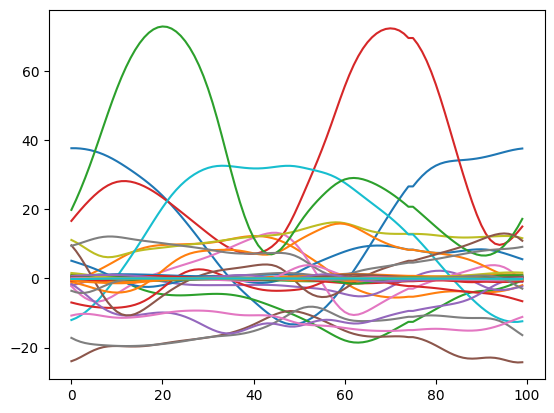

In [22]:
plt.plot(PhaseAveragedPCs_shift[0,:,:].T)

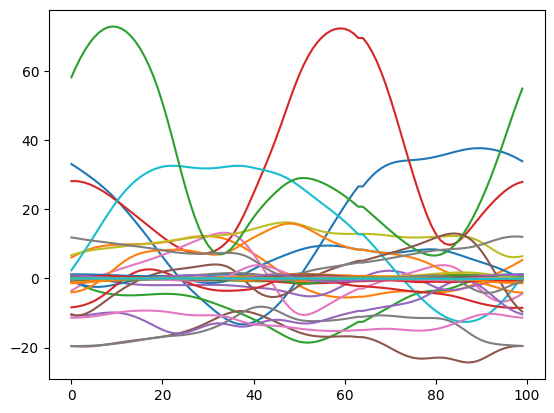

In [23]:
plt.plot(PhaseAveragedPCs_shift_LHS[0,:,:].T)

In [24]:
trial = 1
display(GaitPhases_phsavg_fill_shift[trial])
display(GaitPhases_phsavg_fill_shift_LHS[trial])

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

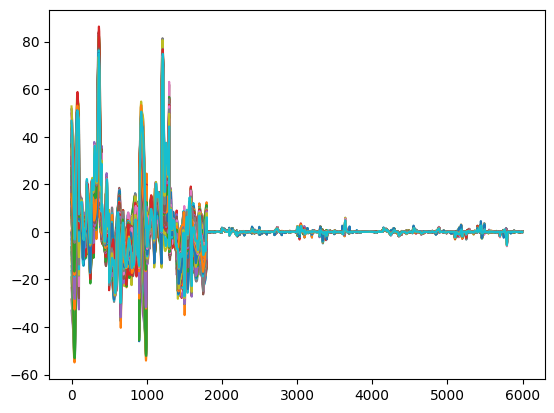

In [25]:
plt.plot(Gaitsignatures.T)

### Dissimilarity of signatures to AB centroid

In [26]:
import numpy as np
from sklearn.manifold import MDS

# Step 1: Define your data
# Let's assume your data is stored in a (72, 600) numpy array called "sample_vectors",
# where each row represents a sample vector.

sample_vectors = Gaitsignatures_trunc6 # Gait Signatures


# Step 3: Compute the dissimilarity matrix
dissimilarity_matrix = np.zeros((len(speed), len(speed)))
for i in range(len(speed)):
    for j in range(len(speed)):
        dissimilarity_matrix[i, j] = np.linalg.norm(sample_vectors[i] - sample_vectors[j])

        
np.save(path + mod_name + model_name  + '_dissimilarity_matrix.npy', dissimilarity_matrix)

# Step 4: Perform multidimensional scaling
mds = MDS(n_components= 3, dissimilarity='precomputed') # 3D MDS
embedding = mds.fit_transform(dissimilarity_matrix)

np.save(path + mod_name + model_name  + '_embedding.npy', embedding) #embedding

                              

/opt/anaconda3/envs/taniel/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


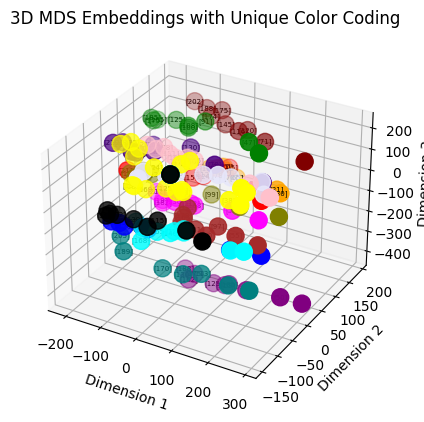

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 8: Plot the MDS embeddings 

# Step 1: Define your data
# Let's assume your embedded points are stored in a (30, 3) numpy array called "embedding",
# where each row represents the 3D coordinates of a data point.

# Step 2: Define your associated vector of numbers
# Let's assume your associated vector is stored in a (30,) numpy array called "associated_vector",
# where each element corresponds to a number associated with a data point.

# Step 3: Plot the 3D MDS embeddings
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', 'P', 'h', 'H', '*', 'x', '+', '.']  # Define marker types for different subjects
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'yellow','black','olive','teal','indigo','brown','pink','lavender','maroon']  # Define colors for different speeds

colorby = SubjectID
#speed
#SubjectID

# Step 4: Scatter plot with unique color coding
unique_numbers = np.unique(colorby) #can change to speed, different outcomes
num_colors = len(unique_numbers)
cmap = plt.get_cmap('tab20')  # You can choose a different colormap if desired

for i, number in enumerate(unique_numbers):
    indices = np.where(colorby == number)
    ax.scatter(embedding[indices, 0], embedding[indices, 1], embedding[indices, 2], s= 150,
               c = colors[i])
 #              c=cmap(i / num_colors), label=f'val: {round(number)}')
    
for j, number in enumerate(speed):
    ax.text(embedding[j, 0], embedding[j, 1], embedding[j, 2],
            f'{number}', fontsize=5, color='black', ha='center', va='center')

# Step 5: Set plot attributes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
#ax.legend()
plt.title('3D MDS Embeddings with Unique Color Coding')

# Step 6: Display the plot
plt.show()


## Classification Accuracy by Subject ID (1, 3-9 subjects) 

In [28]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# Disable the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Assuming you have input data X with shape (600, n_features) and output labels y with shape (600,)
X = Gaitsignatures_trunc6  # GaitSigs
y = np.reshape(SubjectID, (len(speed),)) # Subject numbers

# Initialize an empty list to store the predicted labels
predicted_labels = []

# Perform leave-one-out cross-validation
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the classification model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict the test sample
    y_pred = model.predict(X_test)
    predicted_labels.append(y_pred)

# Concatenate the predicted labels into a single array
predicted_labels = np.concatenate(predicted_labels)

# Calculate accuracy score
accuracy = accuracy_score(y, predicted_labels)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y, predicted_labels)

# Print results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 99.33%
Confusion Matrix:
[[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
